# 02805 Social Graphs and Interactions, Fall 2024

## Project Assignment B

Group members:
 - Ana Marija Pavicic (s232468)
 - Inês	Da Fonseca Tacanho (s232669)
 - Raquel Moleiro Marques (s243636)

#### Imports

In [ ]:
import re
import os
import sys
import nltk
import json
import torch
import urllib
import pickle
import statistics
import numpy as np
import pandas as pd
import polars as pl
from tqdm import tqdm
import networkx as nx
import tensorflow as tf
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
import cartopy.feature as cfeature
from fa2_modified import ForceAtlas2
from traceback import format_exception
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from scipy.stats import percentileofscore
from cartopy.io.shapereader import natural_earth
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from disparity_external import disparity_filter, cut_graph, calc_quantiles

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

## Get Cities Data From The Airports Dataset

In [2]:
file_path = 'data/airports.csv'
airports = pd.read_csv(file_path)

# Extract unique cities from the 'City' column
print(f"Number of unique cities in the dataset: {len(set(airports['City']))}")

# Create dictionary with IATA as key and City as value
# Note that IATA stands for International Air Transport Association airport code
airport_city_dict = airports.set_index('IATA')['City'].to_dict()

print(f"Number of unique IATA codes in the dataset: {len(airport_city_dict.keys())}")

Number of unique cities in the dataset: 6956
Number of unique IATA codes in the dataset: 6073


## Get Connections From Flight Route Dataset

In [3]:
file_path = 'data/routes.csv'
routes = pd.read_csv(file_path)

# Filter rows where stops == 0
direct_flights = routes[routes['Stops'] == 0]

# Making sure that we are extracting the right data
# Extract source airports and destination airports from direct flights
source_airports_set = set(direct_flights['Source Airport'])
dest_airports_set = set(direct_flights['Destination Airport'])

# Extract the set of airports that have corresponding cities from the airport_city_dict
airports_set = set(airport_city_dict.keys())

# Find the intersection between destination airports from direct flights and airports with cities
combined_airports = dest_airports_set.intersection(airports_set)

print(f"Number of airports that are in both direct flights and have city data: {len(combined_airports)}")

Number of airports that are in both direct flights and have city data: 3255


## Creating a Directed Graph of Direct Flights

In [4]:
G = nx.DiGraph()

for index, row in direct_flights.iterrows():
   # get airport code
   source_airport = row['Source Airport']
   destination_airport = row['Destination Airport']
   airline = row['Airline']
   airline_id = row['Airline ID']

   # Check if the airport codes exist in the dictionary
   if source_airport in airport_city_dict and destination_airport in airport_city_dict:
      # Get city names based on airport codes
      source_city = airport_city_dict[source_airport]
      destination_city = airport_city_dict[destination_airport]

       # Check if the edge already exists
      if G.has_edge(source_city, destination_city):
         # Increment the weight attribute
         G[source_city][destination_city]['weight'] += 1
      else:
         # Add a new edge with weight = 1 and other attributes
         G.add_edge(source_city, destination_city, weight=1, Airline=airline, Airline_ID=airline_id)
      
print(f"The directed network has {len(G.nodes())} nodes and {len(G.edges())} edges")

The directed network has 3136 nodes and 34614 edges


### Edge Weight Distribution of Directed Graph

In [5]:
# Extract edge weights from the graph
edge_weights = [data['weight'] for _, _, data in G.edges(data=True)]

# Count occurrences of each weight
weight_distribution = Counter(edge_weights)

# Print the edge weight distribution
print("Edge Weight Distribution:")
for weight, count in weight_distribution.items():
    print(f"Weight {weight}: {count} edges")

Edge Weight Distribution:
Weight 1: 18667 edges
Weight 2: 8526 edges
Weight 6: 470 edges
Weight 5: 882 edges
Weight 3: 3691 edges
Weight 4: 1665 edges
Weight 7: 267 edges
Weight 8: 171 edges
Weight 9: 94 edges
Weight 11: 30 edges
Weight 14: 13 edges
Weight 12: 37 edges
Weight 10: 65 edges
Weight 13: 13 edges
Weight 25: 1 edges
Weight 15: 10 edges
Weight 17: 6 edges
Weight 24: 1 edges
Weight 16: 4 edges
Weight 18: 1 edges


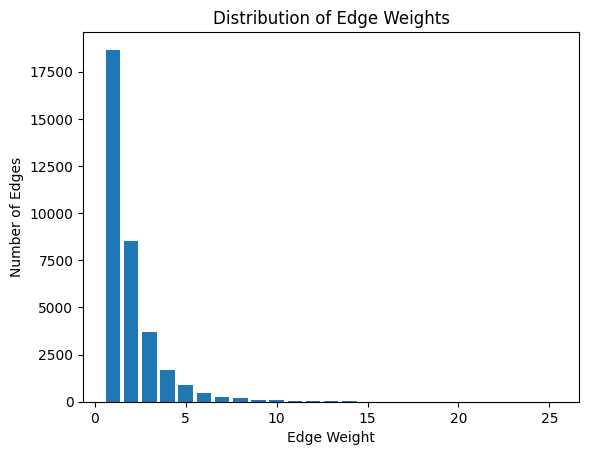

In [6]:
# Visualize the edge weight distribution
plt.bar(weight_distribution.keys(), weight_distribution.values())
plt.xlabel('Edge Weight')
plt.ylabel('Number of Edges')
plt.title('Distribution of Edge Weights')
plt.show()

## Turn the Directed Graph into Undirected

In [7]:
G_undirected = nx.Graph()

# Iterate through all edges in the directed graph G
for u, v, data in G.edges(data=True):
    weight = data['weight']  # Get the weight (number of flights)

    # If the edge already exists in the undirected graph, sum the weights
    if G_undirected.has_edge(u, v):
        G_undirected[u][v]['weight'] += weight
    else:
        # Otherwise, add the edge with the initial weight
        G_undirected.add_edge(u, v, weight=weight)

# Find the largest connected component
largest_component = sorted(nx.connected_components(G_undirected), key=len, reverse=True)
# Create a subgraph from the largest component
G_largest = G_undirected.subgraph(largest_component[0])

# Display the number of nodes and edges in the undirected graph
print(f"The undirected graph has {len(G_largest.nodes())} nodes and {len(G_largest.edges())} edges")

"""
pos = ForceAtlas2(verbose=False).forceatlas2_networkx_layout(G_largest, pos=None, iterations=50)

plt.figure(figsize=(10, 8))

nx.draw(G_largest, pos, with_labels=True, node_size=150, font_size=8, node_color='skyblue', edge_color='gray', width=0.5)

# Get the edge weights to display on the plot
edge_labels = nx.get_edge_attributes(G_largest, 'weight')

# Draw the edge labels (weights)
nx.draw_networkx_edge_labels(G_largest, pos, edge_labels=edge_labels, font_size=8)

plt.title("Largest Connected Component of the Undirected Graph with Weights")
plt.show()"""

The undirected graph has 3130 nodes and 17692 edges


'\npos = ForceAtlas2(verbose=False).forceatlas2_networkx_layout(G_largest, pos=None, iterations=50)\n\nplt.figure(figsize=(10, 8))\n\nnx.draw(G_largest, pos, with_labels=True, node_size=150, font_size=8, node_color=\'skyblue\', edge_color=\'gray\', width=0.5)\n\n# Get the edge weights to display on the plot\nedge_labels = nx.get_edge_attributes(G_largest, \'weight\')\n\n# Draw the edge labels (weights)\nnx.draw_networkx_edge_labels(G_largest, pos, edge_labels=edge_labels, font_size=8)\n\nplt.title("Largest Connected Component of the Undirected Graph with Weights")\nplt.show()'

In [8]:
for node in G_largest.nodes():
    # Filter the DataFrame for matching city
    matched_rows = airports.loc[airports['City'] == node, ['Latitude', 'Longitude']]
    
    if not matched_rows.empty:
        # Extract latitude and longitude if a match is found
        lat, lon = matched_rows.values[0]
        G_largest.nodes[node]['coords'] = (lon, lat)
    else:
        # Handle nodes without matching coordinates
        print(f"Coordinates not found for node: {node}")

Coordinates not found for node: nan


In [9]:
# Create a mutable copy of the frozen graph
G = nx.Graph(G_largest)

# List to store nodes without matching coordinates
nodes_to_remove = []

for node in list(G.nodes()):
    # Filter the DataFrame for matching city
    matched_rows = airports.loc[airports['City'] == node, ['Latitude', 'Longitude']]
    
    if not matched_rows.empty:
        # Extract latitude and longitude if a match is found
        lat, lon = matched_rows.values[0]
        G.nodes[node]['coords'] = (lon, lat)
    else:
        # Add the node to the removal list
        print(f"Coordinates not found for node: {node}")
        nodes_to_remove.append(node)

# Remove nodes that do not have matching coordinates
G.remove_nodes_from(nodes_to_remove)

print(f"Removed {len(nodes_to_remove)} nodes without coordinates.")
print(f"Remaining nodes in graph: {len(G.nodes())}")

Coordinates not found for node: nan
Removed 1 nodes without coordinates.
Remaining nodes in graph: 3129


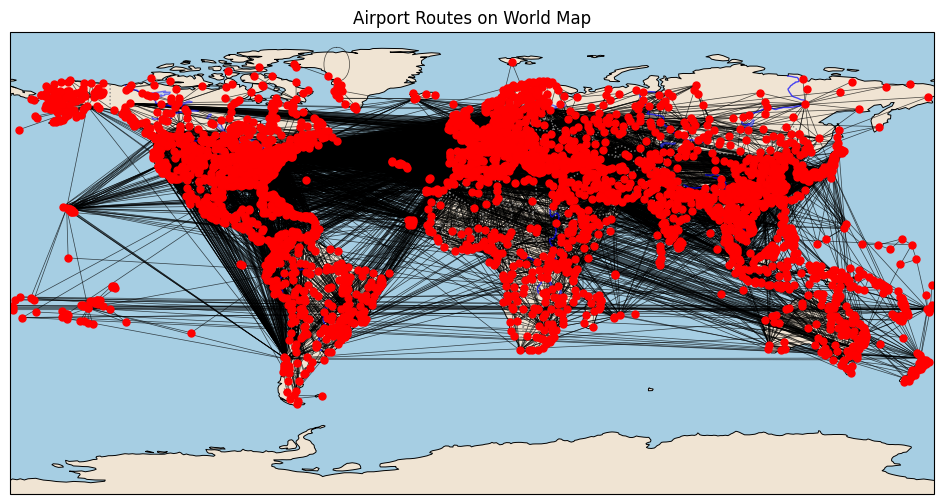

In [10]:
positions = {node: data['coords'] for node, data in G.nodes(data=True)}

# Set up the map using Cartopy
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Enhanced map styling
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# Add detailed features
ax.add_feature(cfeature.LAND, facecolor="#f0e4d3")  # Light beige for land
ax.add_feature(cfeature.OCEAN, facecolor="#a6cee3")  # Light blue for oceans
ax.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=0.7)
ax.add_feature(cfeature.BORDERS, linestyle=":", edgecolor="gray")
ax.add_feature(cfeature.LAKES, facecolor="#a6cee3", edgecolor="blue", alpha=0.5)
ax.add_feature(cfeature.RIVERS, edgecolor="blue", alpha=0.7)

# Optionally, add gridlines
#gridlines = ax.gridlines(draw_labels=True, color="gray", linestyle="--", linewidth=0.5)
#gridlines.top_labels = False
#gridlines.right_labels = False

# Draw the graph
nx.draw_networkx_edges(G, positions, ax=ax, edge_color='black', alpha=0.7, width=0.5)
nx.draw_networkx_nodes(G, positions, ax=ax, node_size=25, node_color='red')

# Show the plot
plt.title("Airport Routes on World Map")
plt.show()

### Saving and loading the graph to pickle

In [11]:
# Save the graph to a file using pickle
with open('flight_network_graph.pickle', 'wb') as f:
   pickle.dump(G, f)

In [12]:
# Load the graph from the pickle file
with open('flight_network_graph.pickle', 'rb') as f:
   G = pickle.load(f)

## Scrape City Information from Wikipedia

In [38]:
def get_wikipedia_page(name):
  """
  Fetch the Wikipedia page for a given city name using the Wikipedia API.
  Returns the raw JSON data from the query response.
  """

  baseurl = "https://en.wikipedia.org/w/api.php?"
  action = "action=query"
  urltitle = f"titles={name}" # City name to query
  content = "prop=revisions&rvprop=content&rvslots=main"
  dataformat ="format=json"

  query = f"{baseurl}{action}&{urltitle}&{content}&{dataformat}"

  # Send the query request to the Wikimedia API and get the response
  wikiresponse = urllib.request.urlopen(query)
  wikidata = wikiresponse.read()
  wikitext = wikidata.decode('utf-8')
  data = json.loads(wikitext)
  return data

def get_wikitext_content(data):
   """
    Extracts the content (wikicode) from the API response.
    Traverses the data structure to find and return the actual content.
    """
   if isinstance(data, dict):
      for key, value in data.items():
         if key == '*':
               return value
         result = get_wikitext_content(value)
         if result:
               return result
   elif isinstance(data, list):
      for item in data:
         result = get_wikitext_content(item)
         if result:
               return result
   return None

def clean_city_name (city_name):
  """
  Cleans the city name by replacing spaces with underscores and encoding it for URL use.
  """
  cleaned_name = str(city_name).replace(" ", "_") # Replace spaces with underscores
  cleaned_name = urllib.parse.quote(cleaned_name) # URL encode the city name
  return cleaned_name

def get_content(name):
  """
  Retrieves the content for a given city name by cleaning the name, fetching the Wikipedia page,
  and extracting the content.
  """
  city = clean_city_name(name) # Clean and prepare the city name
  data = get_wikipedia_page(city) # Get the page data
  content = get_wikitext_content(data) # Extract the content from the page data
  return content

def redirect (content):
  """
  This funciton redirect to the right page in case there is a need
  """
  if content is not None and "#REDIRECT" in content.upper():
    # get the redirect link
    matches = re.findall(r'\[\[(.*?)\]\]', content)
    redirect_name = matches[0]
    content = get_content(redirect_name)

  return content

def may_refer_to_city(content):
  """
  In case there are more pages with the same name
  """
  if content is not None and len(content) < 6000 and ("may refer to" in content.lower() or "refers to" in content.lower()):
    matches = re.findall(r'\[\[(.*?)\]\](?=.*\b(capital|city|town)\b)', content)
    if len(matches) > 0:
      name = matches[0]
      content = get_content(name)
      content = redirect(content)
  return content

## Fetching Wikipedia Content for Cities

In [40]:
nodes_to_remove = []

output_dir = "./new_cities"
os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists

# Iterate through the nodes with a progress bar
for node in tqdm(G.nodes(), desc="Processing nodes", unit="node"):

    try:
        file_name = node + ".txt"
        output_file = os.path.join(output_dir, file_name)
        # Try to fetch the Wikipedia page and get the content
        content = get_content(node)

        # chech for redirect
        content = redirect(content)

        # chech to may refer to
        content = may_refer_to_city(content)

        # if content is not None and len(content) < 6000:
        #   # in case there are multiple pages with the same name we take the first city/town name
        #   if content is not None and ("may refer to" in content.lower() or "refers to" in content.lower()):
        #     if "capital" in content.lower():
        #         # find the city it refers to by looking at the link that is right before the name city
        #         matches = re.findall(r'\[\[(.*?)\]\](?=.*capital)', content)
        #         last_match_before_city = matches[0] if matches else None
        #         if last_match_before_city is not None:
        #             city = clean_city_name(last_match_before_city)
        #             data = get_wikipedia_page(city)
        #             content = get_wikitext_content(data)
        #             if content is not None:
        #                 start_end_dict[node] = last_match_before_city
        #     elif "city" in content.lower():
        #         # find the city it refers to by looking at the link that is right before the name city
        #         matches = re.findall(r'\[\[(.*?)\]\](?=.*city)', content)
        #         last_match_before_city = matches[0] if matches else None
        #         if last_match_before_city is not None:
        #             city = clean_city_name(last_match_before_city)
        #             data = get_wikipedia_page(city)
        #             content = get_wikitext_content(data)
        #             if content is not None:
        #                 start_end_dict[node] = last_match_before_city
        #     # do the same for the town
        #     elif "town" in content.lower():
        #         # find the city it refers to by looking at the link that is right before the name city
        #         matches = re.findall(r'\[\[(.*?)\]\](?=.*town)', content)
        #         last_match_before_city = matches[0] if matches else None
        #         if last_match_before_city is not None:
        #             city = clean_city_name(last_match_before_city)
        #             data = get_wikipedia_page(city)
        #             content = get_wikitext_content(data)
        #             if content is not None:
        #                 start_end_dict[node] = last_match_before_city

        #     # chech for redirect
        #     content = redirect(content)

        if content is None or len(content) < 6000:
          nodes_to_remove.append(node)
        else:
            G.nodes[node]['Content'] = content
            with open(output_file, 'w', encoding='utf-8') as file:
                file.write(content)

    except Exception as e:
        nodes_to_remove.append(node)
        # If an error occurs, print the error message and the node
        print(f"Failed to get content for node {node}: {e}")
        continue  # Continue to the next node if there's an error


Processing nodes:  90%|████████▉ | 2820/3136 [10:47<01:17,  4.05node/s]

Failed to get content for node nan: unsupported operand type(s) for +: 'float' and 'str'


Processing nodes: 100%|██████████| 3136/3136 [11:55<00:00,  4.39node/s]


In [41]:
print(len(G.nodes))
print(len(nodes_to_remove))

3136
884


In [42]:
G.remove_nodes_from(nodes_to_remove)

In [50]:
G_undirected = G.to_undirected()
print("Number of nodes: ", len(G.nodes()))
print("Number of edges:", len(G.edges()))
print("Number of edges of undirected graph: ", len(G_undirected.edges()))

Number of nodes:  2252
Number of edges: 26808
Number of edges of undirected graph:  13650


In [45]:
# Save the graph to a file using pickle
with open('flight_with_content_pretty_good.pickle', 'wb') as f:
   pickle.dump(G, f)

## Extract History From the Wikipedia Scrapped Files

In [ ]:
def find_history(wiki_content):
   # Search for a section titled "History" in the wiki content
   match = re.search(r'==\s*History\s*==([\s\S]*?)(?=\n==[^=]+==)', wiki_content)
   if match:
      history_text = match.group(1).strip()  # Extract the matched text and strip leading/trailing whitespace
      return history_text
   else:
      return None

## Text Cleanup and Historical Content Extraction from Files

In [ ]:
def remove_nested_braces(text):
    # Stack to track opening braces and a list for the result
    stack = []
    result = []
    i = 0

    while i < len(text):
        # Check for opening {{, push to stack when found
        if text[i:i+2] == "{{":
            if len(stack) == 0:  # Only start removing when we find the outermost {{
                result.append('')  # Start ignoring text within the outer block
            stack.append("{{")  # Push opening '{{' to stack
            i += 2  # Skip past the opening '{{'
        
        # Check for closing }}, pop from stack when found
        elif text[i:i+2] == "}}":
            if stack:
                stack.pop()  # Pop from the stack when closing '}}' is found
            if len(stack) == 0:  # When we reach the outermost closing '}}'
                result.append('')  # Add empty string to remove content
            i += 2  # Skip past the closing '}}'
        
        # If we are outside any {{}} block, add the character to the result
        else:
            if not stack:
                result.append(text[i])  # Only add text if not inside a {{}} block
            i += 1  # Move to the next character

    return ''.join(result)

In [ ]:
def clean_history(history):
   text = history

   # Use regular expressions to clean unwanted patterns
   
   # Remove all occurrences of the pattern [[File: ... ]] including any nested content inside
   # This handles image file references that might appear in wiki-style text
   text = re.sub(r'\[\[File:[^\[\]]*(?:\[\[[^\[\]]*\]\][^\[\]]*)*\]\]', '', text) # file remove, nested

   # Replace any occurrence of [[...]] with just the inner text (removes the brackets)
   text = re.sub(r'\[\[(.*?)\]\]', r'\1', text)
   text = remove_nested_braces(text)

   # Remove any content wrapped in {{...}} (likely templates)
   text = re.sub(r'{{(.*?)}}', '', text, flags=re.DOTALL)

   # Remove any reference tags <ref>...</ref> which are used for citations in wiki-style texts
   text = re.sub(r'<ref.*?>.*?</ref>', '', text, flags=re.DOTALL)
   
   # Remove any gallery tags <gallery>...</gallery>, typically used for images in wiki content
   text = re.sub(r'<gallery.*?>.*?</gallery>', '', text, flags=re.DOTALL)
   
   return text.strip()

# Open the file "Miami.txt" from the 'history' directory in read mode
with open("history/Miami.txt", 'r', encoding='utf-8') as file:
   file_content = file.read()
   
   # Clean the extracted history content using the clean_history function
   cleaned = clean_history(file_content)
   with open("ana.txt", "w", encoding="utf-8") as file_out:
      file_out.write(cleaned)

### Extract and Transfer Historical Content from Files

In [ ]:
# Specify source and destination directories
source_dir = 'new_cities/'
destination_dir = 'history/'

# Create the destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Iterate over the files in the source directory
count = 0
for filename in os.listdir(source_dir):
   source_path = os.path.join(source_dir, filename)
   destination_path = os.path.join(destination_dir, filename)
   
   # Check if it's a file (not a directory)
   if os.path.isfile(source_path):
      # Open the file in read mode and read its content
      with open(source_path, 'r', encoding='utf-8') as file:
         file_content = file.read()
      
      history = find_history(file_content)
      if history is not None:
         count += 1
         with open(destination_path, "w", encoding="utf-8") as file:
            file.write(history)

   else:
      print(f"Skipped (not a file): {source_path}")

print("File transfer complete!")
print("Successfully extracted history:", count)

### Clean the History Text

In [ ]:
history_dir = 'history/'

# Create the destination directory if it doesn't exist
os.makedirs(history_dir, exist_ok=True)

# Iterate over the files in the source directory
count = 0
for filename in os.listdir(history_dir):
   file_path = os.path.join(history_dir, filename)
   
   # Check if it's a file (not a directory)
   if os.path.isfile(file_path):
      # Open the file in read mode and read its content
      with open(file_path, 'r', encoding='utf-8') as file:
         file_content = file.read()
      history = clean_history(file_content)
      with open(file_path, "w", encoding="utf-8") as file:
         file.write(history)
         count += 1

   else:
      print(f"Skipped (not a file): {source_path}")

print("File transfer complete!")
print("Successfully extracted history:", count)

____

In [ ]:
with open('/content/drive/MyDrive/graph_with_content.pickle', 'rb') as f:
   G_loaded = pickle.load(f)
print(len(G_loaded.edges()))

## Text Processing and Embedding Generation with Transformers

In [ ]:
def get_transformers_word_embeddings(model: AutoModel):
    # Extracts and returns the word embedding weights from a pre-trained transformer model
    # The embedding weights are returned as a NumPy array in the CPU memory.
    return model.embeddings.word_embeddings.weight.data.to("cpu").numpy()

def generate_embeddings_with_transformers(
    model: AutoModel,
    tokenizer: AutoTokenizer,
    text_list: list[str],
    batch_size: int = 8,
    device: str = None,
    disable_tqdm: bool = False,
) -> torch.Tensor:
    """
    Generates embeddings for a list of texts using a pre-trained transformer model.

    Args:
        model_name (str): The name of the pre-trained transformer model to use.
        text_list (list of str): A list of texts to generate embeddings for.
        batch_size (int): The batch size to use for generating embeddings. Defaults to 8.
        device (str): The device to use for generating embeddings (e.g., "cpu", "cuda").
            If None, defaults to the first available GPU or CPU.

    Returns:
        embeddings (torch.Tensor): A tensor containing the embeddings for the input texts.
            The shape of the tensor is (num_texts, embedding_dim), where num_texts is the number
            of input texts and embedding_dim is the dimensionality of the embeddings produced by
            the pre-trained model.

    Examples:
    >>> model_name = "bert-base-uncased"
    >>> text_list = ["hello world", "how are you"]
    >>> batch_size = 2
    >>> device = "cpu"
    >>> model = AutoModel.from_pretrained(model_name)
    >>> tokenizer = AutoTokenizer.from_pretrained(model_name)
    >>> embeddings_tensor = generate_embeddings_with_transformers(model, tokenizer, text_list, batch_size, device)
    >>> print(embeddings_tensor)
        tensor([[-0.0243,  0.1144,  0.0830,  ..., -0.2666,  0.1662,  0.1519],
                [ 0.0827,  0.0877, -0.0688,  ..., -0.4381,  0.0462, -0.1446]])
    >>> print(embeddings_tensor.shape)
        torch.Size([2, 768])
    """
    device = get_torch_device(use_gpu=True) if device is None else device
    model = model.to(device)

    tokenized_text = tokenizer(
        text_list, padding=True, truncation=True, return_tensors="pt"
    )
    feature_names = list(tokenized_text)

    dataset = TensorDataset(
        tokenized_text["input_ids"], tokenized_text["attention_mask"]
    )
    dataloader = DataLoader(dataset, batch_size=batch_size)
    embeddings = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Encoding", disable=disable_tqdm):
            inputs = {feat: t.to(device) for feat, t in zip(feature_names, batch)}
            outputs = model(
                **inputs,
                output_hidden_states=True,
            )
            embeddings.append(outputs.last_hidden_state[:, 0, :].squeeze(dim=1))
    return torch.vstack(embeddings)


def convert_text2encoding_with_transformers(
    df: pl.DataFrame,
    tokenizer: AutoTokenizer,
    column: str,
    max_length: int = 512,
) -> pl.DataFrame:
    """Converts text in a specified DataFrame column to tokens using a provided tokenizer.
    Args:
        df (pl.DataFrame): The input DataFrame containing the text column.
        tokenizer (AutoTokenizer): The tokenizer to use for encoding the text. (from transformers import AutoTokenizer)
        column (str): The name of the column containing the text.
        max_length (int, optional): The maximum length of the encoded tokens. Defaults to None.
    Returns:
        pl.DataFrame: A new DataFrame with an additional column containing the encoded tokens.
    Example:
    >>> from transformers import AutoTokenizer
    >>> import polars as pl
    >>> df = pl.DataFrame({
            'text': ['This is a test.', 'Another test string.', 'Yet another one.']
        })
    >>> tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    >>> encoded_df, new_column = convert_text2encoding_with_transformers(df, tokenizer, 'text', max_length=20)
    >>> print(encoded_df)
        shape: (3, 2)
        ┌──────────────────────┬───────────────────────────────┐
        │ text                 ┆ text_encode_bert-base-uncased │
        │ ---                  ┆ ---                           │
        │ str                  ┆ list[i64]                     │
        ╞══════════════════════╪═══════════════════════════════╡
        │ This is a test.      ┆ [2023, 2003, … 0]             │
        │ Another test string. ┆ [2178, 3231, … 0]             │
        │ Yet another one.     ┆ [2664, 2178, … 0]             │
        └──────────────────────┴───────────────────────────────┘
    >>> print(new_column)
        text_encode_bert-base-uncased
    """
    text = df[column].to_list()
    # set columns
    new_column = f"{column}_encode_{tokenizer.name_or_path}"
    # If 'max_length' is provided then set it, else encode each string its original length
    padding = "max_length" if max_length else False
    encoded_tokens = tokenizer(
        text,
        add_special_tokens=False,
        padding=padding,
        max_length=max_length,
        truncation=True,
    )["input_ids"]
    return df.with_columns(pl.Series(new_column, encoded_tokens)), new_column

def concat_str_columns(df: pl.DataFrame, columns: list[str]) -> pl.DataFrame:
    """
    >>> df = pl.DataFrame(
            {
                "id": [1, 2, 3],
                "first_name": ["John", "Jane", "Alice"],
                "last_name": ["Doe", "Doe", "Smith"],
            }
        )
    >>> concatenated_df, concatenated_column_name = concat_str_columns(df, columns=['first_name', 'last_name'])
    >>> concatenated_df
        shape: (3, 4)
        ┌─────┬────────────┬───────────┬──────────────────────┐
        │ id  ┆ first_name ┆ last_name ┆ first_name-last_name │
        │ --- ┆ ---        ┆ ---       ┆ ---                  │
        │ i64 ┆ str        ┆ str       ┆ str                  │
        ╞═════╪════════════╪═══════════╪══════════════════════╡
        │ 1   ┆ John       ┆ Doe       ┆ John Doe             │
        │ 2   ┆ Jane       ┆ Doe       ┆ Jane Doe             │
        │ 3   ┆ Alice      ┆ Smith     ┆ Alice Smith          │
        └─────┴────────────┴───────────┴──────────────────────┘
    """
    concat_name = "-".join(columns)
    concat_columns = df.select(pl.concat_str(columns, separator=" ").alias(concat_name))
    return df.with_columns(concat_columns), concat_name

In [ ]:
print(G_loaded.nodes())

## Aggregate History and Demography Data for Graph Nodes

In [ ]:
# Initialize an empty DataFrame with the required columns and explicit types
text_df = pl.DataFrame({"node": pl.Series([], dtype=pl.Utf8),
                        "history": pl.Series([], dtype=pl.Utf8),
                        "demography": pl.Series([], dtype=pl.Utf8)})

# Process files in the `history` folder
for filename in os.listdir('/content/drive/MyDrive/history'):
    filename_wo_txt = os.path.splitext(filename)[0]
    if filename_wo_txt in G_loaded.nodes():
        with open(os.path.join('/content/drive/MyDrive/history', filename), 'r', encoding='utf-8') as file:
            content = file.read()
        new_row = pl.DataFrame({"node": [filename_wo_txt], "history": [content], "demography": [None]})
        text_df = pl.concat([text_df, new_row], how="vertical", rechunk=True)

# Process files in the `demography` folder
for filename in os.listdir('/content/drive/MyDrive/demography'):
    filename_wo_txt = os.path.splitext(filename)[0]
    if filename_wo_txt in G_loaded.nodes():
        with open(os.path.join('/content/drive/MyDrive/demography', filename), 'r', encoding='utf-8') as file:
            content = file.read()
        new_row = pl.DataFrame({"node": [filename_wo_txt], "history": [None], "demography": [content]})
        text_df = pl.concat([text_df, new_row], how="vertical", rechunk=True)

# Combine rows for the same `node` manually
nodes = text_df["node"].unique()
aggregated_data = []

for node in nodes:
    node_data = text_df.filter(text_df["node"] == node)
    history = node_data["history"].drop_nulls().to_list()[0] if not node_data["history"].drop_nulls().is_empty() else None
    demography = node_data["demography"].drop_nulls().to_list()[0] if not node_data["demography"].drop_nulls().is_empty() else None
    aggregated_data.append({"node": node, "history": history, "demography": demography})

text_df = pl.DataFrame(aggregated_data)

In [ ]:
text_df

### Extract and Clean Demography Data from Nodes

In [ ]:
demography_df = text_df.select(["node", "demography"])
demography_df = demography_df.with_columns(pl.col("demography").cast(pl.Utf8))
demography_df = demography_df.filter(pl.col("demography").is_not_null())

## Economy processing

HERE WE ARE ONLY LOOKING INTO DEMOGRAPHY?

In [ ]:
# Pre-trained transformer model to use for Named Entity Recognition (NER)
TRANSFORMER_MODEL_NAME = "dslim/bert-base-NER"
# Column in the DataFrame that contains the text for generating embeddings
TEXT_COLUMNS_TO_USE = ['demography']

# Load the pre-trained transformer model and tokenizer from Hugging Face
transformer_model = AutoModel.from_pretrained(TRANSFORMER_MODEL_NAME)
transformer_tokenizer = AutoTokenizer.from_pretrained(TRANSFORMER_MODEL_NAME)

# This retrieves the word embeddings from the model (weights of the word embeddings layer)
word2vec_embedding = get_transformers_word_embeddings(transformer_model)
# Converts the text in the 'demography' column into tokenized embeddings using the transformer tokenizer
demography_embeddings_df, token_col_title = convert_text2encoding_with_transformers(demography_df, transformer_tokenizer, TEXT_COLUMNS_TO_USE[0])

In [ ]:
demography_embeddings_df.head()

### Computing Cosine Similarities for City Demography Embeddings

In [ ]:
cities = demography_embeddings_df['node'].to_list()
embeddings = np.vstack(demography_embeddings_df[token_col_title].to_list())

# Compute the cosine similarity matrix
cosine_similarities = cosine_similarity(embeddings)

# Put in a dataframe
cosine_similarities_dslim = pd.DataFrame(cosine_similarities, index=cities, columns=cities)

In [ ]:
print("Mean: ", cosine_similarities_dslim.mean().mean())
'''print(f'{cosine_similarities_dslim.mean().idxmax()} is the city with the most similarities with an average of {cosine_similarities_dslim.mean().max()}')
print(f'{cosine_similarities_dslim.mean().idxmin()} is the city with the least similarities with an average of {cosine_similarities_dslim.mean().min()}')
'''
print("Max: ", cosine_similarities_dslim.mean().max())
print("Min: ", cosine_similarities_dslim.mean().min())
print("Median: ", cosine_similarities_dslim.mean().median())
print("Std: ", cosine_similarities_dslim.mean().std())

In [ ]:
G_demo = nx.Graph()

for city1 in cosine_similarities_dslim.index:
    for city2 in cosine_similarities_dslim.columns:
        if city1 != city2:  # Exclude self-loops
            weight = cosine_similarities_dslim.loc[city1, city2]
            if weight > 0:  # Optional: Add a threshold to include only significant weights
                G_demo.add_edge(city1, city2, weight=weight)

In [ ]:
'''import matplotlib.pyplot as plt

# Draw the graph
pos = nx.spring_layout(G_demo)  # Position nodes using a spring layout
plt.figure(figsize=(10, 8))

# Draw nodes and labels
nx.draw_networkx_nodes(G_demo, pos, node_size=100)

# Draw edges with width proportional to weights
edges = G_demo.edges(data=True)
nx.draw_networkx_edges(
    G_demo,
    pos,
    edgelist=[(u, v) for u, v, _ in edges],
    width=[d['weight'] * 5 for _, _, d in edges]  # Scale weights for better visibility
)

# Add edge labels (weights)
edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in edges}
nx.draw_networkx_edge_labels(G_demo, pos, edge_labels=edge_labels, font_size=10)

plt.title("Graph Representation of Cosine Similarities")
plt.axis("off")  # Turn off the axes
plt.show()'''

In [ ]:
# Save as pickle
with open('/content/drive/MyDrive/graph_with_demography.pickle', 'wb') as f:
   pickle.dump(G_demo, f)

In [ ]:
print("Nodes ", len(G_demo.nodes()))
print("Edges ", len(G_demo.edges()))

## History Data Processing with TF-IDF and Cosine Similarity

In [ ]:
history_df = text_df.select(["node", "history"])

# Ensure the "history" column is of type string (Utf8) for further processing
history_df = history_df.with_columns(pl.col("history").cast(pl.Utf8))

# Filter out rows where the "history" column is null to only have valid content
history_df = history_df.filter(pl.col("history").is_not_null())

In [ ]:
# get all the tokens that refer to the same genre
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
#stop_words.update(['http','title', 'short', 'description', ' ', 'wa'])

city_history_dict = {}
for row in history_df.iter_rows(named=True):
    city = row["node"]
    city_text = row["history"]

    # Tokenize text
    tokens = word_tokenize(city_text)
    # Convert to lowercase and remove punctuation
    tokens = [word.lower() for word in tokens if word.isalnum()]
    # Lemmatize tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    # remove single characters
    tokens = [word for word in tokens if len(word) > 1]

    content = " ".join(tokens)
    city_history_dict[city] = content

In [ ]:
# Calculate TF-IDF for each genre
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=2, stop_words="english")
tfidf_matrix = tfidf_vectorizer.fit_transform(city_history_dict.values())
feature_names = tfidf_vectorizer.get_feature_names_out()

In [ ]:
# Extract the list of cities (nodes) from the 'node' column in the history_df dataframe
cities = history_df['node'].to_list()

# Compute the cosine similarity matrix for the TF-IDF matrix
cosine_sim_matrix = cosine_similarity(tfidf_matrix)

# Create a dataframe to store the cosine similarities
cosine_similarities_tfidf = pd.DataFrame(cosine_sim_matrix, index=cities, columns=cities)

In [ ]:
# This cell is below - to delete?
"""
G_hist = nx.Graph()

for city1 in cosine_similarities_tfidf.index:
    for city2 in cosine_similarities_tfidf.columns:
        if city1 != city2:  # Exclude self-loops
            weight = cosine_similarities_tfidf.loc[city1, city2]
            if weight > 0:  # Optional: Add a threshold to include only significant weights
                G_hist.add_edge(city1, city2, weight=weight)
                
# Save as pickle
with open('/content/drive/MyDrive/graph_with_history.pickle', 'wb') as f:
   pickle.dump(G_hist, f)"""

In [ ]:
print("Mean: ", cosine_similarities_tfidf.mean().mean())
'''print(f'{cosine_similarities_dslim.mean().idxmax()} is the city with the most similarities with an average of {cosine_similarities_dslim.mean().max()}')
print(f'{cosine_similarities_dslim.mean().idxmin()} is the city with the least similarities with an average of {cosine_similarities_dslim.mean().min()}')
'''
print("Max: ", cosine_similarities_tfidf.mean().max())
print("Min: ", cosine_similarities_tfidf.mean().min())
print("Median: ", cosine_similarities_tfidf.mean().median())
print("Std: ", cosine_similarities_tfidf.mean().std())

In [ ]:
# Extract top 100 words for each city
top_words_per_city = {}
for city in cities:
    city_tfidf_vector = tfidf_matrix[cities.index(city)]
    # Get indices of top 100 words based on TF-IDF scores
    top_word_indices = city_tfidf_vector.toarray()[0].argsort()[-100:][::-1]
    # Get actual words using feature names
    top_words = [feature_names[i] for i in top_word_indices]
    top_words_per_city[city] = top_words

# Filter TF-IDF matrix to include only top words
all_top_words = set().union(*top_words_per_city.values())  # Combine top words from all cities
top_word_indices = [i for i, word in enumerate(feature_names) if word in all_top_words]
filtered_tfidf_matrix = tfidf_matrix[:, top_word_indices]

In [ ]:
# Check word clouds from top 100 words of 2 cities
for city in cities:
    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(top_words_per_city[city]))

    # Display the generated Word Cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for {city}")

In [ ]:
# Compute the cosine similarity matrix for the filtered TF-IDF matrix (only top words) 
cosine_similarities_tfidf_top = cosine_similarity(filtered_tfidf_matrix)

# Create a dataframe to store the cosine similarities for the top words
cosine_similarities_tfidf_top = pd.DataFrame(cosine_similarities_tfidf_top, index=cities, columns=cities)
cosine_similarities_tfidf_top

In [ ]:
print("Mean: ", cosine_similarities_tfidf_top.mean().mean())
'''print(f'{cosine_similarities_dslim.mean().idxmax()} is the city with the most similarities with an average of {cosine_similarities_dslim.mean().max()}')
print(f'{cosine_similarities_dslim.mean().idxmin()} is the city with the least similarities with an average of {cosine_similarities_dslim.mean().min()}')
'''
print("Max: ", cosine_similarities_tfidf_top.mean().max())
print("Min: ", cosine_similarities_tfidf_top.mean().min())
print("Median: ", cosine_similarities_tfidf_top.mean().median())
print("Std: ", cosine_similarities_tfidf_top.mean().std())

In [ ]:
G_hist = nx.Graph()

for city1 in cosine_similarities_tfidf.index:
    for city2 in cosine_similarities_tfidf.columns:
        if city1 != city2:  # Exclude self-loops
            weight = cosine_similarities_tfidf.loc[city1, city2]
            if weight > 0:  # Optional: Add a threshold to include only significant weights
                G_hist.add_edge(city1, city2, weight=weight)

In [ ]:
#Save as pickle
with open('/content/drive/MyDrive/graph_with_history.pickle', 'wb') as f:
   pickle.dump(G_hist, f)

In [ ]:
print("Nodes ", len(G_hist.nodes()))
print("Edges ", len(G_hist.edges()))

## City Text Analysis with LDA and Cosine Similarity

In [ ]:
#find number of subsections in text file
def find_all_sections(wiki_content):
    # Match any section with = signs (e.g., ===Section===) and its content
    pattern = r'(={2,}\s*[^=\n]+\s*={2,})([\s\S]*?)(?=\n={2,}[^=]+=*|\Z)'
    matches = re.findall(pattern, wiki_content)

    # Extract section headers and their content into a dictionary
    sections = {}
    for header, content in matches:
        # Clean the header of excess = signs and whitespace
        clean_header = re.sub(r'^={2,}\s*|\s*={2,}$', '', header).strip()
        sections[clean_header] = content.strip()

    return sections

In [ ]:
cities = history_df['node'].to_list()

sub_sections = {}
# Get subsection count of each city
for city in cities:
    with open(f'/content/drive/MyDrive/history/{city}.txt', 'r', encoding='utf-8') as file:
        wiki_content = file.read()
    sections = find_all_sections(wiki_content)
    sub_sections[city] = len(sections)

# Get mean
mean_sub_sections = round(sum(sub_sections.values()) / len(sub_sections))
print(f"Mean number of subsections per city: {mean_sub_sections}")

In [ ]:
# Initialize the CountVectorizer
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')

# Apply the vectorizer to the city history text data to create a term frequency matrix
tf = vectorizer.fit_transform(city_history_dict.values())

# Initialize the Latent Dirichlet Allocation (LDA) model to extract 10 topics
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(tf)

topics = lda.components_  # Word distributions per topic

# Transform the term frequency matrix to get the topic distribution for each city
city_topics = lda.transform(tf)

In [ ]:
# Compute cosine_similarity for LDA
cosine_similarities_lda = cosine_similarity(city_topics)
cosine_similarities_lda = pd.DataFrame(cosine_similarities_lda, index=cities, columns=cities)

In [ ]:
print("Mean: ", cosine_similarities_lda.mean().mean())
print(f'{cosine_similarities_lda.mean().idxmax()} is the city with the most similarities with an average of {cosine_similarities_lda.mean().max()}')
print(f'{cosine_similarities_lda.mean().idxmin()} is the city with the least similarities with an average of {cosine_similarities_lda.mean().min()}')
# Get the two cities with the highest similarities besides their own

print("Max: ", cosine_similarities_lda.mean().max())
print("Min: ", cosine_similarities_lda.mean().min())
print("Median: ", cosine_similarities_lda.mean().median())
print("Std: ", cosine_similarities_lda.mean().std())

In [ ]:
G_hist = nx.Graph()

for city1 in cosine_similarities_lda.index:
    for city2 in cosine_similarities_lda.columns:
        if city1 != city2:  # Exclude self-loops
            weight = cosine_similarities_lda.loc[city1, city2]
            if weight > 0:  # Optional: Add a threshold to include only significant weights
                G_hist.add_edge(city1, city2, weight=weight)

In [ ]:
#Save as pickle
with open('/content/drive/MyDrive/graph_with_history_lda.pickle', 'wb') as f:
   pickle.dump(G_hist, f)

In [ ]:
print("Nodes ", len(G_hist.nodes()))
print("Edges ", len(G_hist.edges()))

### Disparity filter

In [ ]:
# disparity filter for extracting the multiscale backbone of complex weighted networks

DEBUG = False

def disparity_integral (x, k):
    """
    calculate the definite integral for the PDF in the disparity filter
    """
    assert x != 1.0, "x == 1.0"
    assert k != 1.0, "k == 1.0"
    return ((1.0 - x)**k) / ((k - 1.0) * (x - 1.0))


def get_disparity_significance (norm_weight, degree):
    """
    calculate the significance (alpha) for the disparity filter
    """
    return 1.0 - ((degree - 1.0) * (disparity_integral(norm_weight, degree) - disparity_integral(0.0, degree)))

def report_error (cause_string, logger=None, fatal=False):
    """
    TODO: errors should go to logger, and not be fatal
    """
    etype, value, tb = sys.exc_info()
    error_str = "{} {}".format(cause_string, str(format_exception(etype, value, tb, 3)))

    if logger:
        logger.info(error_str)
    else:
        print(error_str)

    if fatal:
        sys.exit(-1)

def disparity_filter (graph):
    """
    implements a disparity filter, based on multiscale backbone networks
    https://arxiv.org/pdf/0904.2389.pdf
    """
    alpha_measures = []
    
    for node_id in graph.nodes():
        node = graph.nodes[node_id]
        degree = graph.degree(node_id)
        strength = 0.0

        # Use graph.edges to handle undirected edges
        for id0, id1 in graph.edges(node_id):
            edge = graph[id0][id1]
            strength += edge["weight"]

        node["strength"] = strength

        for id0, id1 in graph.edges(node_id):
            edge = graph[id0][id1]

            norm_weight = edge["weight"] / strength
            edge["norm_weight"] = norm_weight

            if degree > 1:
                try:
                    if norm_weight == 1.0:
                        norm_weight -= 0.0001

                    alpha = get_disparity_significance(norm_weight, degree)
                except AssertionError:
                    report_error("disparity {}".format(repr(node)), fatal=True)

                edge["alpha"] = alpha
                alpha_measures.append(alpha)
            else:
                edge["alpha"] = 0.0

    for id0, id1 in graph.edges():
        edge = graph[id0][id1]
        edge["alpha_ptile"] = percentileofscore(alpha_measures, edge["alpha"]) / 100.0

    return alpha_measures

# related metrics

def calc_quantiles (metrics, num):
    """
    calculate `num` quantiles for the given list
    """
    global DEBUG

    bins = np.linspace(0, 1, num=num, endpoint=True)
    s = pd.Series(metrics)
    q = s.quantile(bins, interpolation="nearest")

    try:
        dig = np.digitize(metrics, q) - 1
    except ValueError as e:
        print("ValueError:", str(e), metrics, s, q, bins)
        sys.exit(-1)

    quantiles = []

    for idx, q_hi in q.iteritems():
        quantiles.append(q_hi)

        if DEBUG:
            print(idx, q_hi)

    return quantiles

def cut_graph (graph, min_alpha_ptile=0.5, min_degree=2):
    """
    apply the disparity filter to cut the given graph
    """
    filtered_set = set([])

    for id0, id1 in graph.edges():
        edge = graph[id0][id1]

        if edge["alpha_ptile"] < min_alpha_ptile:
            filtered_set.add((id0, id1))

    for id0, id1 in filtered_set:
        graph.remove_edge(id0, id1)

    filtered_set = set([])

    for node_id in graph.nodes():
        node = graph.nodes[node_id]

        if graph.degree(node_id) < min_degree:
            filtered_set.add(node_id)

    for node_id in filtered_set:
        graph.remove_node(node_id)

In [ ]:
"""G_disparity = G_largest.copy()

alpha_measures = disparity_filter(G_disparity)
print("Alpha measures calculated:", alpha_measures)

quantiles = calc_quantiles(alpha_measures, num = 10)

# Determine alpha cutoff (median, 30th percentile)
min_alpha_ptile = 0.3
alpha_cutoff = quantiles[int(min_alpha_ptile * (len(quantiles) - 1))]
print(f"Using alpha cutoff at {min_alpha_ptile * 100}% percentile: {alpha_cutoff}")

# Filter the graph based on the cutoff
cut_graph(G_disparity, min_alpha_ptile=min_alpha_ptile)

print(f"There were {len(G_largest.nodes())} nodes and {len(G_largest.edges())} edges in un-filtered graph")
print(f"There are currently {len(G_disparity.nodes())} nodes and {len(G_disparity.edges())} edges in filtered graph")
"""